In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
import talib

---

## Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: Import the OHLCV dataset into a Pandas DataFrame.

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("BTC-AUD.csv"), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-10-09,399.171661,435.658539,391.848328,416.601227,416.601227,95458918
2014-10-10,416.214355,427.426758,405.331879,416.306274,416.306274,50277145
2014-10-11,416.075989,422.787567,409.845703,417.154877,417.154877,15365803
2014-10-12,417.508331,437.739990,410.067963,436.267151,436.267151,20229111
2014-10-13,435.543365,453.506134,422.562439,446.136444,446.136444,40248429


In [3]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["Close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
# signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns
Date,,
2014-10-09,416.601227,NaN
2014-10-10,416.306274,-0.000708
2014-10-11,417.154877,0.002038
2014-10-12,436.267151,0.045816
2014-10-13,446.136444,0.022622


,Close,Actual Returns
Date,,
2023-10-05,43926.378906,0.010259
2023-10-06,43045.859375,-0.020045
2023-10-07,43775.996094,0.016962
2023-10-08,43810.835938,0.000796
2023-10-09,43768.171875,-0.000974


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [4]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

# Add MACD
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9

signals_df['macd'], signals_df['macdSignal'], signals_df['macdHist'] = talib.MACD(signals_df['Close'], fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)
signals_df

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist
Date,,,,,,,
2015-01-16,253.036240,-0.008687,250.892029,404.683580,-36.792825,-26.597234,-10.195591
2015-01-17,242.290848,-0.042466,242.351833,402.940476,-38.771560,-29.032099,-9.739461
2015-01-18,255.793518,0.055729,251.593556,401.335349,-38.802875,-30.986254,-7.816621
2015-01-19,262.313507,0.025489,253.358528,399.786935,-37.865097,-32.362023,-5.503075
2015-01-20,258.901001,-0.013009,254.824719,398.013273,-36.971083,-33.283835,-3.687248


,Close,Actual Returns,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist
Date,,,,,,,
2023-10-05,43926.378906,0.010259,43538.310547,43031.339336,562.980640,271.561881,291.418759
2023-10-06,43045.859375,-0.020045,43431.859375,43002.548008,564.027279,330.054961,233.972319
2023-10-07,43775.996094,0.016962,43557.133789,42984.380391,616.664159,387.376800,229.287359
2023-10-08,43810.835938,0.000796,43639.767578,42962.390703,653.655615,440.632563,213.023052
2023-10-09,43768.171875,-0.000974,43600.215821,42942.654609,671.785057,486.863062,184.921995


In [5]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist,Signal
Date,,,,,,,,
2015-01-16,253.036240,-0.008687,250.892029,404.683580,-36.792825,-26.597234,-10.195591,-1.0
2015-01-17,242.290848,-0.042466,242.351833,402.940476,-38.771560,-29.032099,-9.739461,-1.0
2015-01-18,255.793518,0.055729,251.593556,401.335349,-38.802875,-30.986254,-7.816621,1.0
2015-01-19,262.313507,0.025489,253.358528,399.786935,-37.865097,-32.362023,-5.503075,1.0
2015-01-20,258.901001,-0.013009,254.824719,398.013273,-36.971083,-33.283835,-3.687248,-1.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist,Signal
Date,,,,,,,,
2023-10-05,43926.378906,0.010259,43538.310547,43031.339336,562.980640,271.561881,291.418759,1.0
2023-10-06,43045.859375,-0.020045,43431.859375,43002.548008,564.027279,330.054961,233.972319,-1.0
2023-10-07,43775.996094,0.016962,43557.133789,42984.380391,616.664159,387.376800,229.287359,1.0
2023-10-08,43810.835938,0.000796,43639.767578,42962.390703,653.655615,440.632563,213.023052,1.0
2023-10-09,43768.171875,-0.000974,43600.215821,42942.654609,671.785057,486.863062,184.921995,-1.0


In [6]:
signals_df['Signal'].value_counts()

 1.0    1687
-1.0    1502
Name: Signal, dtype: int64

<Axes: xlabel='Date'>

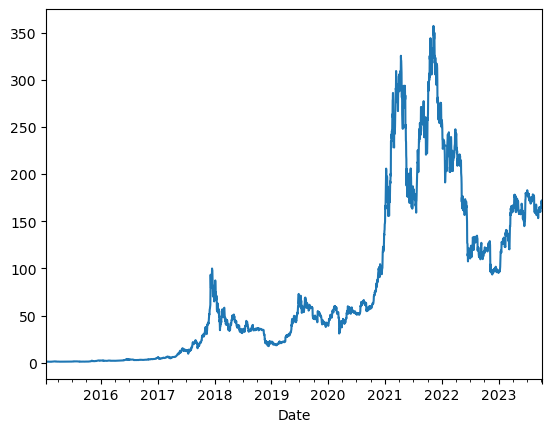

In [7]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Actual Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [8]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow','macd','macdSignal','macdHist']].dropna() #removed shift()

# Review the DataFrame
X

,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist
Date,,,,,
2015-01-16,250.892029,404.683580,-36.792825,-26.597234,-10.195591
2015-01-17,242.351833,402.940476,-38.771560,-29.032099,-9.739461
2015-01-18,251.593556,401.335349,-38.802875,-30.986254,-7.816621
2015-01-19,253.358528,399.786935,-37.865097,-32.362023,-5.503075
2015-01-20,254.824719,398.013273,-36.971083,-33.283835,-3.687248
...,...,...,...,...,...
2023-10-05,43538.310547,43031.339336,562.980640,271.561881,291.418759
2023-10-06,43431.859375,43002.548008,564.027279,330.054961,233.972319
2023-10-07,43557.133789,42984.380391,616.664159,387.376800,229.287359


In [9]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']
display(y)
# Review the value counts
y.value_counts()

Date
2015-01-16   -1.0
2015-01-17   -1.0
2015-01-18    1.0
2015-01-19    1.0
2015-01-20   -1.0
             ... 
2023-10-05    1.0
2023-10-06   -1.0
2023-10-07    1.0
2023-10-08    1.0
2023-10-09   -1.0
Name: Signal, Length: 3189, dtype: float64

 1.0    1687
-1.0    1502
Name: Signal, dtype: int64

In [10]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-01-16 00:00:00


In [11]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=36)

# Display the training end date
print(training_end)

2018-01-16 00:00:00


In [12]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train

,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist
Date,,,,,
2015-01-16,250.892029,404.683580,-36.792825,-26.597234,-10.195591
2015-01-17,242.351833,402.940476,-38.771560,-29.032099,-9.739461
2015-01-18,251.593556,401.335349,-38.802875,-30.986254,-7.816621
2015-01-19,253.358528,399.786935,-37.865097,-32.362023,-5.503075
2015-01-20,254.824719,398.013273,-36.971083,-33.283835,-3.687248
...,...,...,...,...,...
2018-01-12,18112.080078,13520.731406,-129.734626,221.364228,-351.098853
2018-01-13,17978.679200,13646.698345,-191.811096,138.729163,-330.540259
2018-01-14,17562.050781,13764.613506,-297.053428,51.572645,-348.626073


In [13]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(days=1):]
y_test = y.loc[training_end+DateOffset(days=1):]

# Review the X_test DataFrame
# X_train.head()
display(X_test.head())
display(y_test.head())

,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist
Date,,,,,
2018-01-17,15809.304932,14045.034658,-930.910901,-316.655292,-614.255609
2018-01-18,15038.601807,14126.963516,-1096.008392,-472.525912,-623.482480
2018-01-19,14328.974365,14210.375532,-1197.492554,-617.519240,-579.973314
2018-01-20,14760.722168,14302.226050,-1134.383152,-720.892023,-413.491129
2018-01-21,14876.142334,14375.616758,-1203.305347,-817.374688,-385.930660


Date
2018-01-17   -1.0
2018-01-18    1.0
2018-01-19    1.0
2018-01-20    1.0
2018-01-21   -1.0
Name: Signal, dtype: float64

In [14]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [27]:
# From SVM, instantiate SVC classifier model instance
svm_model = SVC(kernel='rbf', random_state=50,gamma='auto')
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
results = pd.DataFrame({
    "Prediction": svm_pred, 
    "Actual": y_test
}).reset_index(drop=True)
results



,Prediction,Actual
0,-1.0,-1.0
1,-1.0,1.0
2,-1.0,1.0
3,-1.0,1.0
4,-1.0,-1.0
...,...,...
2087,1.0,1.0
2088,1.0,-1.0
2089,1.0,1.0
2090,1.0,1.0


In [28]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, svm_pred))

Accuracy: 0.5023900573613767


### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [29]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.48      0.13      0.20      1032
         1.0       0.51      0.87      0.64      1060

    accuracy                           0.50      2092
   macro avg       0.49      0.50      0.42      2092
weighted avg       0.49      0.50      0.42      2092



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [30]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Actual Returns'] * predictions_df["Predicted"]

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2018-01-17,-1.0,-0.026396,0.026396
2018-01-18,-1.0,0.021233,-0.021233
2018-01-19,-1.0,0.013446,-0.013446
2018-01-20,-1.0,0.111291,-0.111291
2018-01-21,-1.0,-0.101948,0.101948


,Predicted,Actual Returns,Strategy Returns
Date,,,
2023-10-05,1.0,0.010259,0.010259
2023-10-06,1.0,-0.020045,-0.020045
2023-10-07,1.0,0.016962,0.016962
2023-10-08,1.0,0.000796,0.000796
2023-10-09,1.0,-0.000974,-0.000974


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

In [31]:
s = predictions_df['Strategy Returns'].sum()
s

4.35412029081469

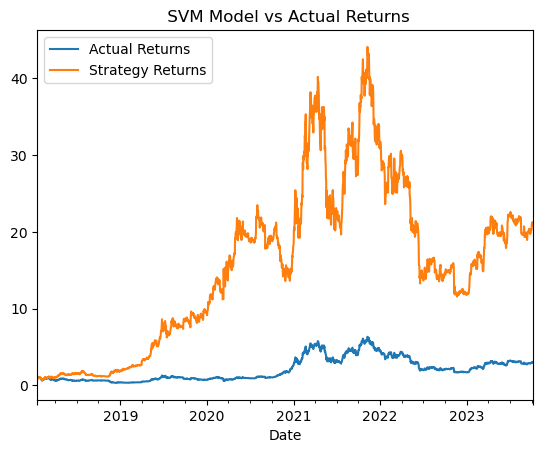

In [32]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(title=' SVM Model vs Actual Returns')
# (1 + predictions_df["Actual Returns"]).cumprod().plot(title=' SVM Model vs Actual Returns')
plt.savefig('SMA_MACD_SVM_plot.png')